# Transfer learning for Melanoma Classification using EfficientNetB0

## 1. Set up

#### Set up for importing utilities

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Install efficientnet

In [2]:
import efficientnet.tfkeras as efn

 #### Random State

In [3]:
from utilities import random_state
import numpy as np

random_state = random_state() 
np.random.seed(random_state)

#### Export Config

In [4]:
export_results = True
export_folder = f'export'

date_format = "%d%m%Y%H%M%S" # timestamp format in exported files
if export_results:
    import datetime
    import os
    if not os.path.exists(export_folder): 
      os.makedirs(export_folder)
      print("Created new directory %s" %export_folder)

#### Data Setup

In [5]:
img_pixel = 224 # default : 128

downsampled_data = True
base_path = "data" # "data/30" 
current_train_melanoma_percentage = 0.08 # 0.3

max_images_train = 50 # int(13653*1)
max_images_test = 5 # int(5804*1)

flat_data = False

#### Start the timer

In [6]:
import time
start = time.time()

## 2. Get data

#### Get image paths

In [7]:
from utilities import get_all_img_paths, get_img_paths

img_folder_train = base_path + "/train" + ("_downsampled" if downsampled_data else "")
img_folder_test = base_path + "/test" + ("_downsampled" if downsampled_data else "")

img_paths_train = get_img_paths(img_folder_train, max_images_train) 
img_paths_test = get_img_paths(img_folder_test, max_images_test)

#### Load and prepare data

In [8]:
from utilities import load_train_test

groundtruth_file_train = base_path + "/ISIC_2020_2019_train" + ("_downsampled" if downsampled_data else "") + ".csv" 
groundtruth_file_test = base_path + "/ISIC_2020_2019_test" + ("_downsampled" if downsampled_data else "") + ".csv"


# available options
options = ["sequential", # first load train, then load test
           "parallel_train_test", # load train and test parallel (load data within train and test sequential)
           "sequential_train_test_parallel_chunks", # load first train, then test, but load the data within the sets parallel
           "parallel_fusion" # run train and test parallel and parallely load data with train and test 
          ]

# chose an option
option = "parallel_fusion"

df_train, df_test = load_train_test(img_paths_train, groundtruth_file_train, 
                                    img_paths_test, groundtruth_file_test, 
                                    option, img_pixel);

Num images per thread 5
start loading train
start thread #0 for train
start loading test
start thread #1 for train
start thread #0 for test
start thread #2 for train
start thread #3 for train
start thread #4 for train
start thread #5 for train
start thread #6 for train
start thread #7 for train
start thread #8 for train
start thread #9 for train
finished thread #0 for train
finished thread #7 for train
finished thread #4 for train
finished thread #1 for train
finished thread #6 for train
finished thread #9 for train
finished thread #3 for train
finished thread #5 for train
finished thread #2 for train
finished thread #0 for test
done loading test
finished thread #8 for train
done loading train


#### Split into target and predictors

In [9]:
from utilities import split_predictors_target

X_train, y_train = split_predictors_target(df_train) 
X_test, y_test = split_predictors_target(df_test) 

#### Unflatten data

In [10]:
if not flat_data:
    from utilities import unflatten_images_df
    X_train = unflatten_images_df(X_train, img_pixel=img_pixel)
    X_test = unflatten_images_df(X_test, img_pixel=img_pixel)

#### Clean up

In [11]:
import gc

del(df_train)
del(df_test)
del(img_paths_train)
del(img_paths_test)
del(img_folder_train)
del(img_folder_test)
del(groundtruth_file_train)
del(groundtruth_file_test)

gc.collect()

0

## 3. Train model

#### Set up for training

In [12]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau 

lr_frozen = 0.001
lr_unfrozen = 0.00001 # extra low learning rate to avoid overfitting

num_blocks_unfreeze = 4

lr_scheduler_unfrozen = ReduceLROnPlateau(factor=0.5, patience=2)
early_stopping_unfrozen = EarlyStopping(patience=5)

lr_scheduler_frozen = ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping_frozen = EarlyStopping(patience=10)

training_loss = 'binary_crossentropy'
training_weights = 'noisy-student'

activation_function = 'sigmoid'

training_verbose_setting = 0 # needed because of IOPub message rate exceeded error

#### Util functions for training 

In [19]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.callbacks import CSVLogger

melanoma_weight = (1/current_train_melanoma_percentage)/2
class_weight = {0: 1.,
                1: melanoma_weight,}
            
def unfreeze_model(base_model, model, num_blocks = 2): # a function to unfreeze num_layers layers of a model
    # We unfreeze the nth block and all subsequent layers while leaving BatchNorm layers frozen
    max_blocks= 7
    unfreeze_til = max_blocks - num_blocks
    print(f"unfreezing {num_blocks} blocks")
    print(f"unfreezing until {unfreeze_til}")
    for i in reversed(range(len(base_model.layers))):
        if base_model.layers[i].name.startswith('block' + str(unfreeze_til)):
            break
            
    num_layers = len(base_model.layers) - i
    print(f"unfreezing {num_layers} layers")
    model.layers[0].trainable = True
    print(model.layers[0])
    for layer in base_model.layers[:-num_layers]:
            layer.trainable = False
    for layer in base_model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True 
        else:
            layer.trainable = False
            
def compile_model(model, lr=0.001):
    model.compile(loss=training_loss, 
                  optimizer=Nadam(lr), 
                  metrics=['accuracy', Recall(name="recall")])
    
def fit_model(model, early_stopping, lr_scheduler):
    callbacks = [early_stopping, lr_scheduler]
    if export_results:
        filename = export_folder + "/training_log_"+datetime.datetime.now().strftime(date_format)+".csv"
        callbacks.append(CSVLogger(filename, separator=",", append=False))

    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        batch_size=32, epochs=100,
                        class_weight=class_weight,
                        verbose = training_verbose_setting,
                        callbacks=callbacks)
    return history

#### Util functions for evaluation

In [20]:
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import confusion_matrix

def eval_model(model, history, name):
    display_history(history,name)
    gc.collect()
    display_confusion_matrix(model,name)

def display_history(history, name):
    _, axs = pyplot.subplots(3, 1, figsize=(20,15))

    # plot loss during training
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='test')
    axs[0].set_title("Loss")
    axs[0].legend()

    # plot accuracy during training
    axs[1].plot(history.history['accuracy'], label='train')
    axs[1].plot(history.history['val_accuracy'], label='test')
    axs[1].set_title("Accuracy")
    axs[1].legend()

    # plot recall during training
    axs[2].plot(history.history['recall'], label='train')
    axs[2].plot(history.history['val_recall'], label='test')
    axs[2].set_title("Recall")
    axs[2].legend()

    if export_results:
        pyplot.savefig(export_folder + "/loss_and_accuracy_during_training_"+name+"_"+datetime.datetime.now().strftime(date_format)+".png")

    pyplot.show()
    
def display_confusion_matrix(model, name):
    y_pred_continuous = model.predict(X_test)
    y_pred_discrete = (model.predict(X_test) > 0.5).astype("int32")
    y_pred = y_pred_discrete
    
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, digits=4)
    print(f'\nClassification_report=\n{report}')

    if export_results:
        file = open(export_folder + "/classification_report_"+name+"_"+datetime.datetime.now().strftime(date_format)+".txt", 'w')
        file.write(report)
        file.close()
        
    class_names = ["no melanoma", "melanoma"]

    cf = confusion_matrix(y_test, y_pred)
    plot = sns.heatmap(cf, annot= True, fmt=".0f",
               xticklabels = class_names,
               yticklabels = class_names)
    plot.set(xlabel='Prediction', ylabel='Actual')

    if export_results:
        plot.get_figure().savefig(export_folder + '/confusion_matrix_' +name + "_" + datetime.datetime.now().strftime(date_format) + ".png")

#### Build model

In [21]:
import sklearn 
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.metrics import Recall

import keras
from tensorflow.keras import layers

# build model
base_model = efn.EfficientNetB0(input_shape=(img_pixel ,img_pixel , 3),weights=training_weights,include_top=False)
base_model.trainable = False # freezing all the layers

add_model = keras.Sequential(base_model)

add_model.add(GlobalAveragePooling2D(name="avg_pool"))
add_model.add(BatchNormalization())
top_dropout_rate = 0.2
add_model.add(Dropout(top_dropout_rate, name="top_dropout"))
add_model.add(Dense(1, activation=activation_function))
model = add_model

gc.collect()

32673

#### Train model (while still frozen)

In [22]:
compile_model(model, lr=lr_frozen)

In [23]:
history_frozen = fit_model(model, early_stopping_frozen, lr_scheduler_frozen)

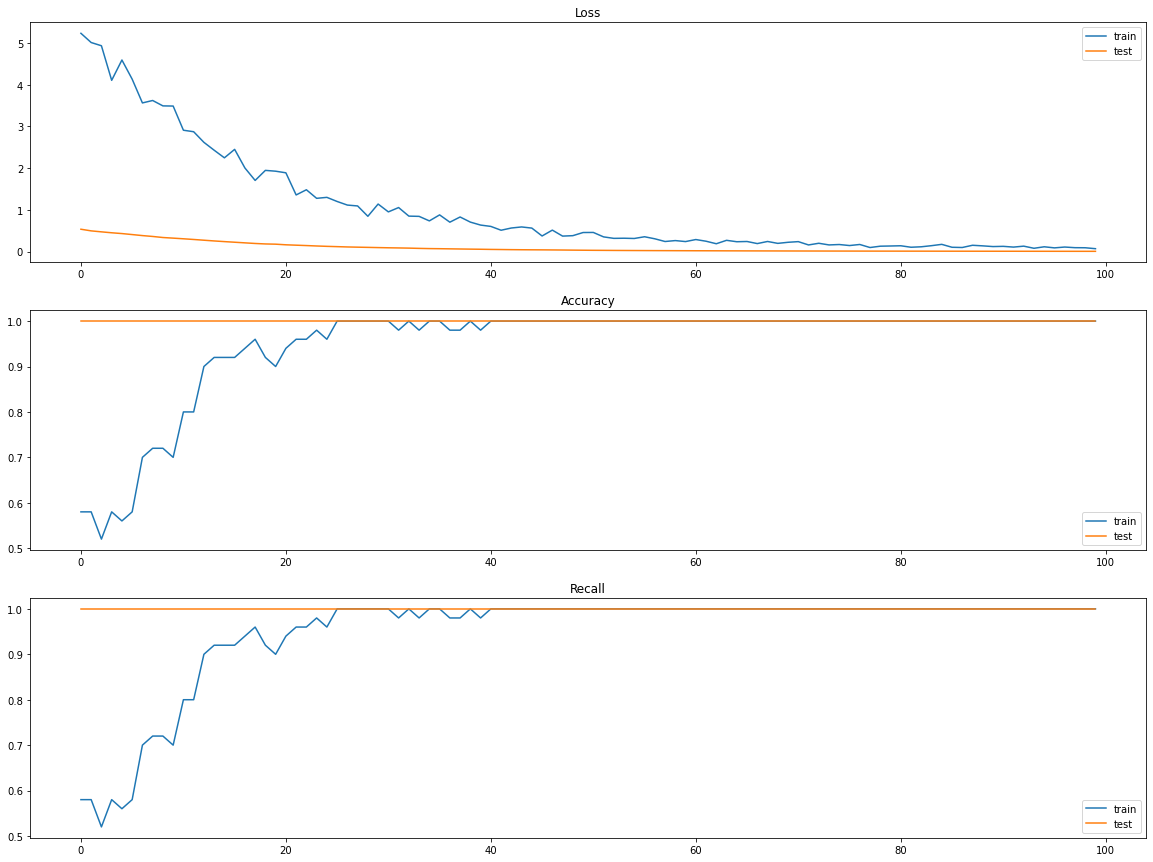


Classification_report=
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         5

    accuracy                         1.0000         5
   macro avg     1.0000    1.0000    1.0000         5
weighted avg     1.0000    1.0000    1.0000         5



1442

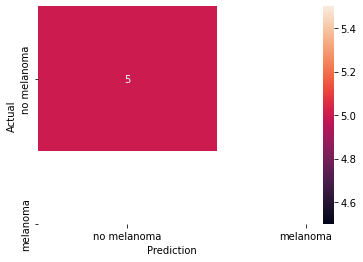

In [24]:
gc.collect()
eval_model(model, history_frozen, "frozen")
gc.collect()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                      

#### Unfreeze and retrain

In [27]:
unfreeze_model(base_model,model,num_blocks_unfreeze)

In [28]:
gc.collect()
compile_model(model, lr=lr_unfrozen) 
gc.collect()

242

In [29]:
history = fit_model(model, early_stopping_unfrozen, lr_scheduler_unfrozen)

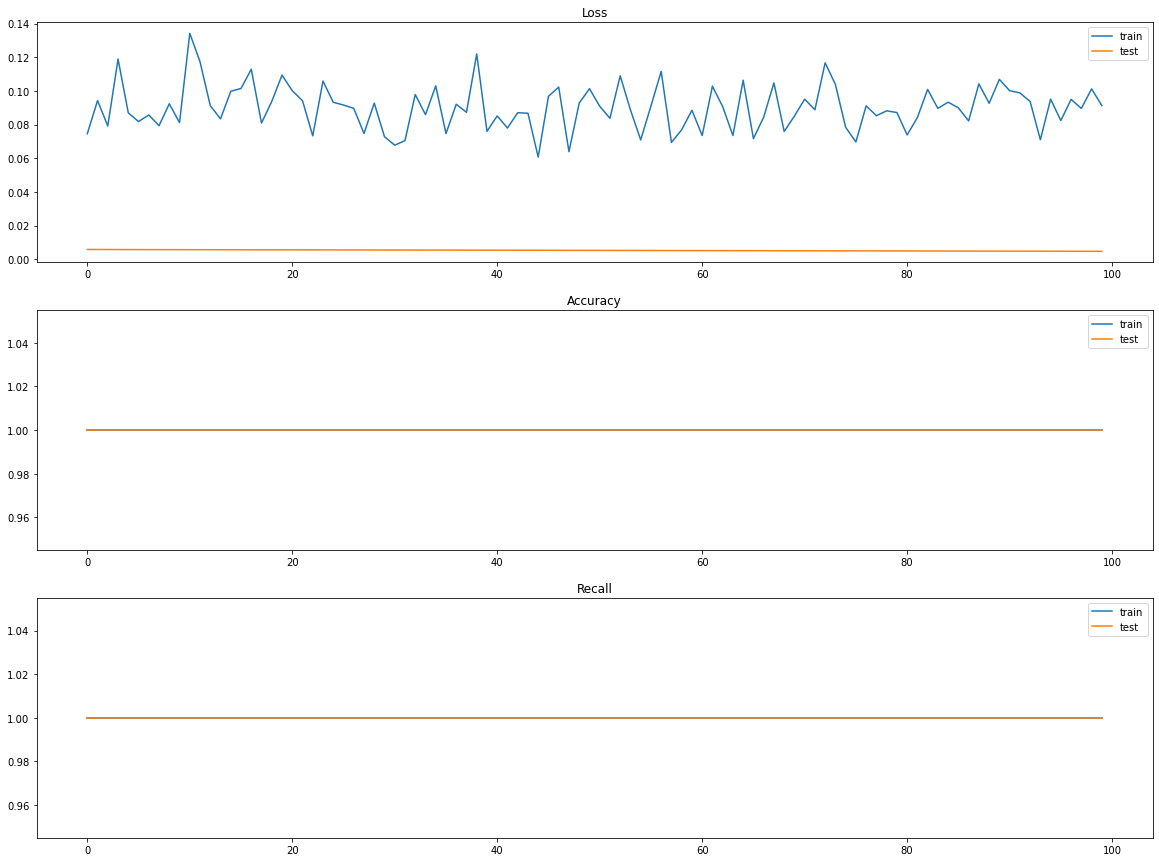


Classification_report=
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         5

    accuracy                         1.0000         5
   macro avg     1.0000    1.0000    1.0000         5
weighted avg     1.0000    1.0000    1.0000         5



1467

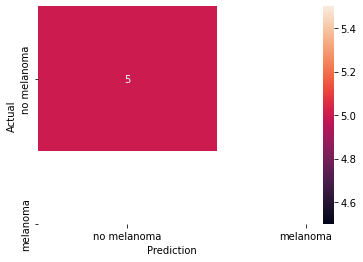

In [30]:
gc.collect()
eval_model(model, history, "unfrozen")
gc.collect()

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                      

#### Save final model

In [32]:
# store model
if export_results:
    model.save(export_folder + "/model_"+datetime.datetime.now().strftime(date_format)+".h5")

#### Stop the timer

In [33]:
stop = time.time()
print(f'It took {stop - start} s to load the data and train the model')

if export_results:
    f = open(f'{export_folder}/overall_time.txt', 'w')
    f.write(f'Time it took : {stop - start} s')
    f.close()

It took 1186.7804553508759 s to load the data and train the model


## 4. Test and evaluate model

#### Predict test set 

In [34]:
y_pred_continuous = model.predict(X_test)
y_pred_discrete = (model.predict(X_test) > 0.5).astype("int32")
y_pred = y_pred_discrete

#### Display images and predictions

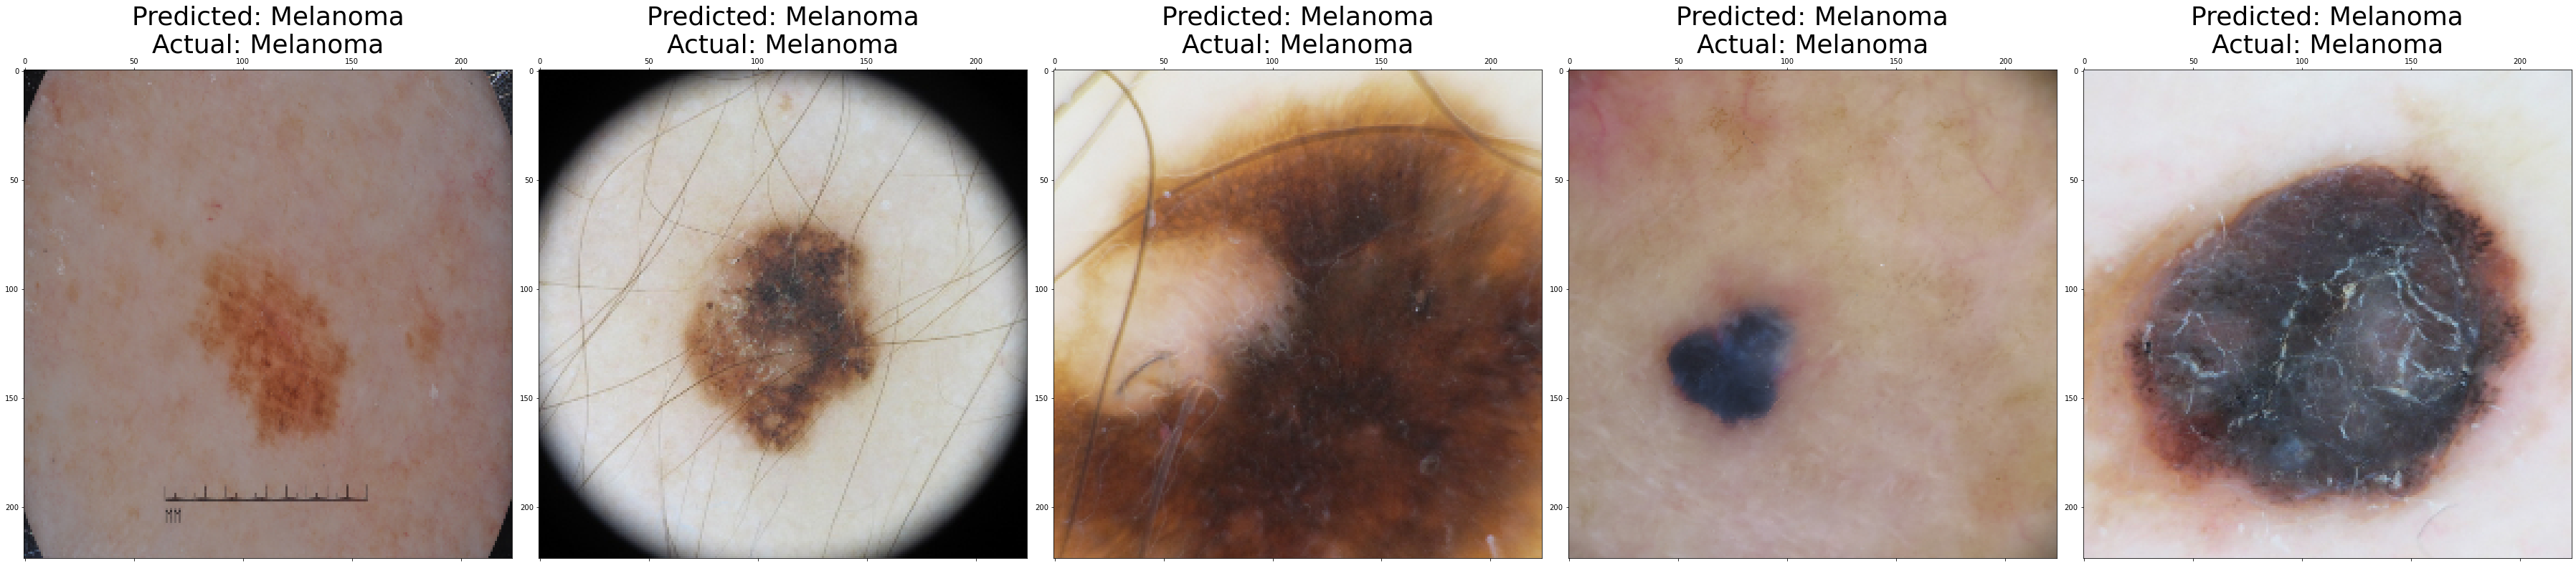

In [35]:
from utilities import display_results

plt_all = display_results(X_test, y_pred, y_test, 15, img_pixel, flat=False)

if export_results:
    plt_all.savefig(export_folder + "/classification_results_"+datetime.datetime.now().strftime(date_format)+".png")

plt_all.show()

#### Display wrongly classified images

In [36]:
from utilities import display_interesting_results

plt_wrong = display_interesting_results(X_test, y_pred, y_test, img_pixel=img_pixel, flat=False)

if export_results:
    plt_wrong.savefig(export_folder + "/incorrect_classification_results_"+datetime.datetime.now().strftime(date_format)+".png")
    
plt_wrong.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 3600x3600 with 0 Axes>